---

# MLP Language Models

---

![](https://www.researchgate.net/publication/354817375/figure/fig2/AS:1071622807097344@1632506195651/Multi-layer-perceptron-MLP-NN-basic-Architecture.jpg)

---

![](https://miro.medium.com/v2/resize:fit:1200/1*EqKiy4-6tuLSoPP_kub33Q.png)

---

In [40]:
# PREPARE DATA
import torch

# read words from file
words = open('./english_verbs.txt', 'r').read().splitlines()
# alternative dataset: https://github.com/dwyl/english-words
#words = open('./words_alpha.txt', 'r').read().splitlines()

print(words[:10])

print('num words: ', len(words)) 

# Prepare Alphabet
## count characters 
dataset_characters = []
for word in words:
    word_characters = list(word)
    dataset_characters.extend(word_characters)
distinct_characters = sorted(list(set(dataset_characters)))
print('len dictinct characters: ', len(distinct_characters))
print('distinct_characters: ', distinct_characters)

special_characters = ['_'] # changed to blank only for convenience reasons

# ngram characters = distinct characters + start token and end token -> + 2
num_characters = len(distinct_characters) + len(special_characters)
print('Num Characters: ', num_characters)

# create a character to index mapping because it is easier to work with indices when using tensor matrices -> every character gets assigned an index
character_to_index_map = {character:index for index, character in enumerate(distinct_characters)}
print(character_to_index_map)

# add our special characters that symbolize start and end of a word
character_to_index_map['_'] = 26
print(character_to_index_map)

# write characters into the cells to make it look more nicely
index_to_character_map = {index:character for character, index in character_to_index_map.items()}
print(index_to_character_map)

['abide', 'accelerate', 'accept', 'accomplish', 'achieve', 'acquire', 'acted', 'activate', 'adapt', 'add']
num words:  1041
len dictinct characters:  26
distinct_characters:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Num Characters:  27
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '_': 26}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y',

In [41]:
# MULTI LAYER PERCEPTRON

# Idea: Lets go for bigger contexts! -> 4 gram model -> 3 tokens context predict the upcoming 4th token

# Tokens: elements of our fundamental set -> for us this is characters, but could also be words, subwords, ... 
# [a,b,c,d,_] -> [0,1,2,3,26] embedding -> indices

# SPLIT DATA INTO TRAIN, DEV, TEST -> 80%, 10%, 10%
import random
random.shuffle(words)
train_num = int(0.8*len(words))
dev_num = int(0.9*len(words)) - train_num
test_num = len(words) - (train_num + dev_num)
print(train_num)
print(dev_num)
print(test_num)

# CREATE DATASET for neural 4 gram model
context_length = 5
X, Y = [], [] # X = inputs, Y = outputs

for word in words: # [:4] 
    context = [26] * context_length # _ _ _ word _
    for character in word + '_': 
        index = character_to_index_map[character]
        X.append(context)
        Y.append(index)
        #print(''.join(index_to_character_map[i] for i in context), ' -> ', index_to_character_map[index])
        context = context[1:] + [index] # crop first context token and append current token as the new last one of the context
        
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X[:4])
print(Y[:4])

X_train, Y_train = X[:train_num], Y[:train_num]
X_dev, Y_dev = X[train_num:train_num+dev_num], Y[train_num:train_num+dev_num]
X_test, Y_test = X[train_num+dev_num:], Y[train_num+dev_num:]

832
104
105
tensor([[26, 26, 26, 26, 26],
        [26, 26, 26, 26,  3],
        [26, 26, 26,  3,  4],
        [26, 26,  3,  4, 18]])
tensor([ 3,  4, 18,  2])


In [11]:
# EMBEDDING LAYER: Embedding Table -> condensed representation of tokens
import torch.nn.functional as F

emb_dim = 2
emb_layer = torch.randn((27,emb_dim)) 
# get emebbing of index 5
#print(emb_layer[5])
# but how to get it when using one hot encoding? -> just multiply! -> the nature of a one hot vector extracts the embedding from the weights. 
character_embedding = F.one_hot(torch.tensor(5), num_classes=num_characters).float() @ emb_layer
#print(character_embedding)
# get embeddings of a list or tensor
character_embeddings = emb_layer[torch.tensor([5,6,7])]
#print(character_embeddings)
# or the embeddings of whole tensors
x_emb = emb_layer[X_train]
#print(x_emb)
print(x_emb.shape)

# HIDDEN LAYER 
input_dim = context_length * emb_dim
hidden_dim = 100
output_dim = num_characters

W1 = torch.randn((input_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
## concatenate the first, second and third embeddings into one input_context = roll up the 3 into 1
num_training_examples = x_emb.shape[0]
x_input = x_emb.view(num_training_examples, input_dim) # view is very memory efficient
print(x_input.shape)
# get hidden representation
h = torch.tanh(x_input @ W1 + b1)
print(h.shape)

# FINAL LAYER/OUTPUT LAYER
W2 = torch.randn((hidden_dim, output_dim))
b2 = torch.randn(output_dim)
logits = h @ W2 + b2
print(logits.shape)
# apply softmax
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
print(probs.shape)
print(probs[0].sum())

# COMPUTE LOSS
## get the current output probs for every gold standard character -> compute negative log likelihood loss (if sum of probs on gold standard places is high -> then neg log likelihood loss goes to 0)
loss = -probs[torch.arange(num_training_examples), Y_train].log().mean()
print(loss.item())

# count params of MLP
parameters = [emb_layer, W1, b1, W2, b2]
num_params = sum(p.nelement() for p in parameters)
print(num_params)

torch.Size([832, 3, 2])
torch.Size([832, 6])
torch.Size([832, 100])
torch.Size([832, 27])
torch.Size([832, 27])
tensor(1.)
18.325881958007812
3481


In [42]:
# CONCISE DESCRIPTION OF MLP
## params
emb_dim = 2
input_dim = context_length * emb_dim
hidden_dim = 100
output_dim = num_characters
learning_rate = 0.1
num_epochs = 1000

# emb layer
emb_layer = torch.randn((27,emb_dim)) 
# hidden layer
W1 = torch.randn((input_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
# output layer
W2 = torch.randn((hidden_dim, output_dim))
b2 = torch.randn(output_dim)
# params/weights
parameters = [emb_layer, W1, b1, W2, b2]

# activate gradients for all variables in the compute graph
for p in parameters:
    p.requires_grad = True

In [17]:
# TRAINING
for epoch in range(num_epochs):
    # FORWARD PASS
    x_emb = emb_layer[X_train] # (num_training_examples, 3, 2)
    h = torch.tanh(x_emb.view(-1, input_dim) @ W1 + b1) # when using -1 torch will infer first dimension automatically
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train) # more concise way of writing -> use the inbuilt function that does the same as the lines above
    #print(loss.item())
    # BACKWARD PASS
    ## set the gradients to be zero
    for p in parameters:
        p.grad = None
    # compute gradients
    loss.backward()
    # update weights
    for p in parameters:
        p.data += -learning_rate * p.grad
        
print(loss.item())

2.165377378463745


2.3102657794952393


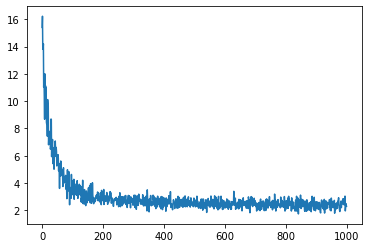

In [43]:
# TRAINING with minibatches
import matplotlib.pyplot as plt
%matplotlib inline

epochs_list = []
loss_list = []

for epoch in range(num_epochs):
    # minibatch construction -> get random batch of 32 examples
    batch_ix = torch.randint(0, X_train.shape[0], (32,))
    # FORWARD PASS
    x_emb = emb_layer[X_train[batch_ix]] # (35, 3, 2)
    h = torch.tanh(x_emb.view(-1, input_dim) @ W1 + b1) # when using -1 torch will infer first dimension automatically
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[batch_ix]) # more concise way of writing -> use the inbuilt function that does the same as the lines above
    #print(loss.item())
    # BACKWARD PASS
    ## set the gradients to be zero
    for p in parameters:
        p.grad = None
    # compute gradients
    loss.backward()
    # update weights
    for p in parameters:
        p.data += -learning_rate * p.grad
    # log loss
    epochs_list.append(epoch)
    loss_list.append(loss.item())
        
print(loss.item())

plt.plot(epochs_list, loss_list)

tensor(3.0368, grad_fn=<NllLossBackward>)
------------------------------------------------------


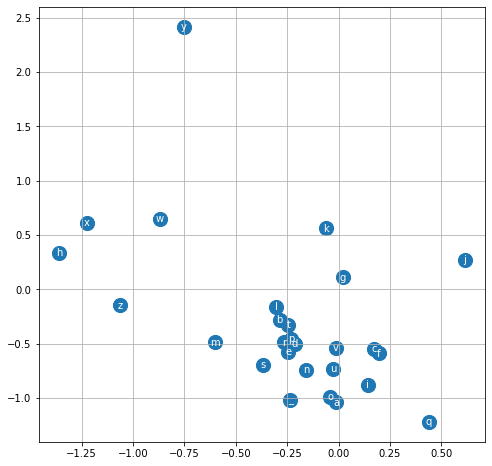

In [44]:
# MODEL EVALUATION
## = compute avg neg log likelihood over our test set
x_emb = emb_layer[X_test]
h = torch.tanh(x_emb.view(-1, input_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print(loss)
print('------------------------------------------------------')

## visualize embedding vectors in the embedding layer
plt.figure(figsize=(8,8))
plt.scatter(emb_layer[:,0].data, emb_layer[:,1].data, s=200)
for i in range(emb_layer.shape[0]):
    plt.text(emb_layer[i,0].item(), emb_layer[i,1].item(), index_to_character_map[i], ha="center", va="center", color="white")
plt.grid("minor")

In [47]:
# SAMPLING 
num_words_to_sample = 5

for i in range(num_words_to_sample):
    out = []
    blank_index = 26 # start with the blank symbol
    context = [blank_index] * context_length
    while True:
        x_emb = emb_layer[torch.tensor([context])] # (1, contextlength, emb_dim)
        h = torch.tanh(x_emb.view(1, input_dim) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sampling
        index = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [index]
        out.append(index_to_character_map[index])
        if index == 26:
            break
    print(''.join(out))

gimifor_
tiuy_
purtjay_
amabe_
steit_


# Model Deployment

**Knowledge Distillation**
- 7B, 13B -> GPT-4 Distillations
    - e.g. mosaic MPT-7B: https://www.mosaicml.com/blog/mpt-7b

**Sparsity Techniques**
- Quantization
    - 8 Quantization: ONNX
    - 4 bit Quantization: https://github.com/PanQiWei/AutoGPTQ
- *Compute Graph Optimization* 
    - huggingface optimum
    - onnx
    - JAX (jax is designed for TPU clusters)
- Weight Sharing
- Weight Pruning
- Low-Rank Adaptation
    - *(Model Fine-Tuning:)* 
        - (Parameter-Efficient Fine-Tuning:) -> more details for peft next week

**Inference Engines/Runtimes**
- ONNX: open-quasi standard: https://github.com/microsoft/onnxruntime
- Python: if you run your backends on python -> just in time compilation framework JAX: https://github.com/AakashKumarNain/TF_JAX_tutorials
- C++: ctranslate, fastertransformers, cformers, -> so far only public repositories but no standard -> support is not guaranteed: https://github.com/OpenNMT/CTranslate2,  https://github.com/antimatter15/cformers
- (Triton)
- (Intel OpenVino)

**Server:** 
- FastAPI + Docker + Kubernetes (Service Architecture): https://www.youtube.com/watch?v=DQRNt8Diyw4&t=354s
- Triton Server: https://github.com/triton-inference-server/server


**=> TAKE AWAYS:**
- if possible, use a distilled model. 
- the most important speed up in inference you will get from QUANTIZATION
- the second most important speed you will get from your inference framework. C++ is the gold standard. ONNX is quite generic and well supported + documented. 

## Questions
- 

---

In [139]:
# EXAMPLES

## Model Fine Tuning Example (main next week)

## Model Quantization, Graph Optimization, ONNX export

## Model Inference Example Docker FastAPI Setup for FLAN-T5 XL inference, Faster IOBInding: https://tryolabs.com/blog/2022/11/24/transformer-based-model-for-faster-inference

## TODO: GPTQ 4 bit quantization for MPT-7B, FLAN-T5 XL ONNX version